<a href="https://colab.research.google.com/github/whyeon92/ESAA_YB/blob/Code_Study/ESAA_HW0401.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#구글 코랩 환경 사용으로 드라이브 마운트 및 디렉터리 설정
from google.colab import drive
drive.mount('/content/gdrive/')

path = "/content/gdrive/My Drive/ESAAData/"

Mounted at /content/gdrive/


# 📌 3-1. 정확도 (Accuracy)

In [2]:
from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):
  #fit() 메서드는 아무것도 학습하지 않음
  def fit(self, X, y = None):
    pass
  #predict() 메서드는 단순히 Sex 피처가 1이면 0, 그렇지 않으면 1로 예측함
  def predict(self, X):
    pred = np.zeros((X.shape[0], 1))
    for i in range(X.shape[0]):
      if X['Sex'].iloc[i] == 1:
        pred[i] = 0
      else:
        pred[i] = 1

    return pred

In [7]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
#Null 처리 함수
def fillna(df):
  df['Age'].fillna(df['Age'].mean(), inplace = True)
  df['Cabin'].fillna('N', inplace = True)
  df['Embarked'].fillna('N', inplace = True)
  df['Fare'].fillna(0, inplace = True)  #숫자형이라서 결측값은 0으로 변환
  return df

#머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
  df.drop(['PassengerId', 'Name', 'Ticket'], axis = 1, inplace = True)
  return df

#레이블 인코딩 수행
def format_features(df):
  df['Cabin'] = df['Cabin'].str[:1]
  features = ['Cabin', 'Sex', 'Embarked']
  for feature in features:
    le = LabelEncoder()
    le = le.fit(df[feature])
    df[feature] = le.transform(df[feature])
  return df

#앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
  df = fillna(df)
  df = drop_features(df)
  df = format_features(df)
  return df

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
titanic_df = pd.read_csv(path + 'titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis = 1)
#transform_features() 사용자 정의 함수라서 이전 챕터 코드 그대로 가져와서 위에 코드셀로 추가적으로 삽입함.
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size = 0.2, random_state = 0)

#위에서 생성한 Dummy Classifier를 이용해 학습/예측/평가 수행
myclf = MyDummyClassifier()  #MyDummyClassifier를 이용해 객체 생성
myclf.fit(X_train, y_train)  #myclf에 fit 메소드 적용

mypredictions = myclf.predict(X_test)
print('Dummy Classifier의 정확도는: {0:.4f}'.format(accuracy_score(y_test, mypredictions)))

Dummy Classifier의 정확도는: 0.7877


In [9]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
  def fit(self, X, y):
    pass

  #입력값으로 들어오는 X 데이터 세트의 크기만큼 모두 0값으로 만들어서 반환
  def predict(self, X):
    return np.zeros((len(X), 1), dtype = bool)

#사이킷런의 내장 데이터 세트인 load_digits()를 이용해 MNIST 데이터 로딩
digits = load_digits()

#digits 번호가 7번이면 True이고 이를 astype(int)로 1로 변환, 7이 아니면 False이고 이를 0으로 변환
y = (digits.target ==7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state = 11)

In [11]:
#불균형한 레이블 데이터 분포도 확인
print('레이블 테스트 세트 크기:', y_test.shape)
print('테스트 세트 레이블 0과 1의 분포도')
print(pd.Series(y_test).value_counts())

#Dummy Classifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는: {:.3f}'.format(accuracy_score(y_test, fakepred)))

레이블 테스트 세트 크기: (450,)
테스트 세트 레이블 0과 1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도는: 0.900


정확도 = (예측결과가 동일한 데이터 건수)/(전체 예측 데이터 건수)  
- 직관적으로 예측 성능을 나타냄
- 레이블이 불균형한 분류의 경우 성능을 왜곡할 수 있음. (1이 다수, 0이 소수인 데이터에서 레이블을 다 1로 예측하면 그나마 성능이 높은 그런 경우...)  

# 📌 3-2. 오차 행렬

In [12]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, fakepred)

array([[405,   0],
       [ 45,   0]])

|TN | FP |
|--|--|
|FN | TP|  

위와 같은 모양의 표로 분류 결과를 한번에 정리할 수 있다.
- TN (True Negative) : 0으로 예측, 실제값도 0
- FP (False Positive) : 1로 예측했는데 실제값은 0
- FN (False Negative) : 0으로 예측했는데 실제값은 1
- TP (True positive): 1로 예측, 실제로도 1
-T/F는 내 예측이 맞냐 틀리냐, 뒤의 Positive, Negative는 내가 예측한 값이 0인지 1인지!
-`confusion_matrix(y_test, pred)` API로 간단하게 오차 행렬을 사용 가능, 이 때 반환 값은 ndarray 형태
- 위에서 다룬 정확도를 (TN+TP)/(TN+TP+FN+FP) 와 같이 표현 가능하다! ~엠비티아이같아...~

# 📌 3-3. 정밀도와 재현율

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  print('오차행렬')
  print(confusion)
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy, precision, recall))

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

#원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
titanic_df = pd.read_csv(path + 'titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis = 1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size = 0.20, random_state = 11)

lr_clf = LogisticRegression()

lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(  
  
지난번 같은 오류 나길래 max_iter를 디폴트보다 크게 늘려봤습니다.  

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

#원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
titanic_df = pd.read_csv(path + 'titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis = 1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size = 0.20, random_state = 11)

lr_clf = LogisticRegression(max_iter = 300)

lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


여전히 다를건 없는데 경고문을 왜 띄우는 건지... 그치만 우선 없앴으니까 된거지...

정밀도(Precision) = TP/(FP+TP)  
 : 1이라고 예측한 애들 중 진짜 1인 비율  
 - Positive 예측 성능을 더욱 정밀하게 측정하기 위한 지표로 양성 예측도라고도 부름  
 - FP를 낮추는 데 초점

재현율(Recall) = TP/(FN+TP)   
 : 실제값이 1인 애들 중 맞게 예측한 비율
 - 민감도 또는 TPR(True Positive Rate)라고도 부름  
 - FN을 낮추는 데 초점
   
업무나 사용분야에 따라 정밀도와 재현율 중 중시할 지표가 달라짐.  
예를 들어 진짜 암환자를 정상이라고 판단하면 큰일이 나니까 이런 경우 재현율이 훨씬 중요해짐!  
다른 예로 스팸메일을 거를 때 스팸메일(1)이 아닌 정상업무메일(0)을 1이라고 판단하면 큰일나니까 이 땐 정밀도가 더 중요함   
그러니까 어디에 어느 지표를 쓸 지 잘 생각해보고 결정해야함.
- 정밀도가 중요! -> 0을 1로 판단하면 영향이 큰 경우
- 재현율이 중요! -> 1을 0으로 판단하게 되면 큰일나는 경우
근데 보통 재현율이 더 중요시되는 경우가 많은 듯 하다~


## 정밀도/재현율 트레이드 오프

In [17]:
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print('pred_proba() 결과 Shape: {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출 \n: ', pred_proba[:3])

#예측 확률 array와 예측 결괏값 array를 병합(concatenate)해 예측 확률과 결괏값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1, 1)], axis = 1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n', pred_proba_result[:3])

pred_proba() 결과 Shape: (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
:  [[0.4621693  0.5378307 ]
 [0.87879062 0.12120938]
 [0.87724729 0.12275271]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.4621693  0.5378307  1.        ]
 [0.87879062 0.12120938 0.        ]
 [0.87724729 0.12275271 0.        ]]


In [18]:
from sklearn.preprocessing import Binarizer

X = [[1, -1, 2],
     [2, 0, 0],
     [0, 1.1, 1.2]]

#X의 개별 원소들이 threshold 값보다 길거나 작으면 0을, 크면 1을 반환
binarizer = Binarizer(threshold = 1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [19]:
from sklearn.preprocessing import Binarizer

#Binarizer의 threshold 설정값. 분류 결정 임계값임.
custom_threshold = 0.5

#predict_proba() 반환값의 두 번째 칼럼, 즉 Positive 클래스 칼럼 하나만 추출해 Binarizer 적용
pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)

binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


In [21]:
#Binarizer의 threshold 설정값을 0.4로 설정. 즉, 분류 결정 임곗값을 0,5에서 0.4로 낮춤
#즉 0.4 보다 크면 Positive로 판단하게 된다는 것!

custom_threshold = 0.4
pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)
binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361


In [22]:
#테스트를 수행할 모든 임계값을 리스트 객체로 저장
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
  #thresholds list 객체 내의 값을 차례로 iteration하면서 Evaluation 수행
  for custom_threshold in thresholds:
    binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_c1)
    custom_predict = binarizer.transform(pred_proba_c1)
    print('임곗값: ', custom_threshold)
    get_clf_eval(y_test, custom_predict)

get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임곗값:  0.4
오차행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361
임곗값:  0.45
오차행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033
임곗값:  0.5
오차행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869
임곗값:  0.55
오차행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541
임곗값:  0.6
오차행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377


In [23]:
from sklearn.metrics import precision_recall_curve

#레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

#실제값 데이터 세트와 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임곗값 배열의 Shape:', thresholds.shape)

#반환된 임곗값 배열 로우가 147건이므로 샘플로 10건만 추출하되, 임곗값을 15step으로 추출
thr_index = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값: ', np.round(thresholds[thr_index], 2))

#15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값
print('샘플 임계값별 정밀도: ', np.round(precisions[thr_index], 3))
print('샘플 임계값별 재현율: ', np.round(recalls[thr_index], 3))

반환된 분류 결정 임곗값 배열의 Shape: (165,)
샘플 추출을 위한 임계값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135 150]
샘플용 10개의 임곗값:  [0.01 0.09 0.11 0.13 0.15 0.23 0.35 0.5  0.63 0.75 0.89]
샘플 임계값별 정밀도:  [0.341 0.372 0.415 0.448 0.505 0.585 0.688 0.774 0.913 0.935 0.938]
샘플 임계값별 재현율:  [1.    1.    0.967 0.918 0.902 0.902 0.869 0.787 0.689 0.475 0.246]


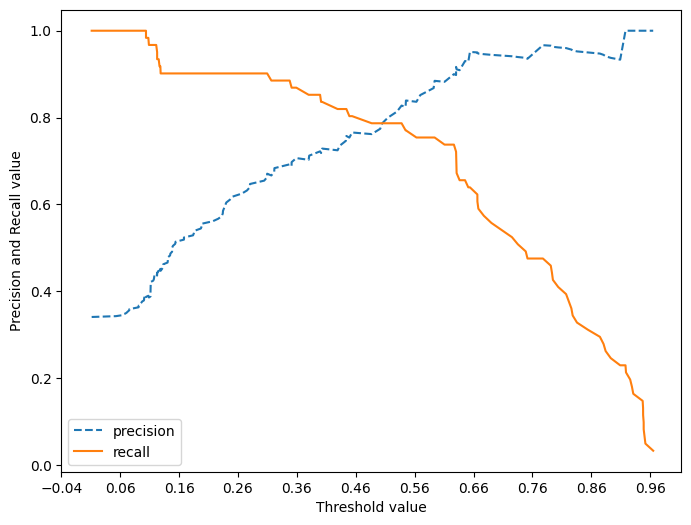

In [24]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
  #threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
  precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

  #X축을 threshold값으로 Y축은 정밀도, 재현율 값으로 각각 Plot 수행, 정밀도는 점선으로 표시
  plt.figure(figsize=(8, 6))
  threshold_boundary = thresholds.shape[0]
  plt.plot(thresholds, precisions[0:threshold_boundary], linestyle = '--', label = 'precision')
  plt.plot(thresholds, recalls[0:threshold_boundary], label = 'recall')

  #threshold 값 X축의 Scale을 0.1 단위로 변경
  start, end = plt.xlim()
  plt.xticks(np.round(np.arange(start, end, 0.1), 2))

  #x축, y축, label과 legend 그리고 grid 설정
  plt.xlabel('Threshold value');plt.ylabel('Precision and Recall value')
  plt.legend();plt.grid
  plt.show()

precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

정밀도와 재현율은 상호보완적 평가지표, 따라서 하나가 오르면 하나는 내려가는 게 당연함.  
: 정밀도/재현율 TradeOff  
사이킷런의 분류 알고리즘은 예측 데이터가 특정 레이블에 속하는지를 계산하기 위해 개별 레이블별 결정 확률을 구하는데, 해당 확률이 큰 레이블값을 `predict()` 메소드의 결과로 내놓음.  
=> 그렇다면! 그 확률을 어떻게 볼 수 있나?  
==> `predict_proba()`메소드로 확률까지 확인 가능
`Binarizer(threshold)` -> 입력값이 threshold값보다 크면 1을 반환, 작으면 0을 반환하는 함수  
- 임계값(threshold)가 커지면 정밀도 ⬆️, 재현율 ⬇️
- 반대로 작아지면 정밀도 ⬇️, 재현율 ⬆️
  
  
정밀도와 재현율 모두 100%가 되는 방법이 있지만, 그 방법은 그저 극단적인 수치조작을 위한 결과일 뿐 결론적으로 좋은 성능을 기대할 수 없게 됨. 따라서 이를 절충한 평가 지표가 필요하고 이는 아래에서 다룸.

# 📌 3-4. F1 Score

In [25]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print('F1 스코어: {0:.4f}'.format(f1))

F1 스코어: 0.7805


In [26]:
def get_clf_eval(y_test, pred):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  #F1 스코어 추가
  f1 = f1_score(y_test, pred)
  print('오차행렬')
  print(confusion)
  #f1 score print 추가
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}'.format(accuracy, precision, recall, f1))

thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임곗값:  0.4
오차행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361, F1: 0.7727
임곗값:  0.45
오차행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033, F1: 0.7840
임곗값:  0.5
오차행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869, F1: 0.7805
임곗값:  0.55
오차행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541, F1: 0.7931
임곗값:  0.6
오차행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377, F1: 0.8036


$F1 score = {2(precision*recall)\over (precision+recall)}$

앞선 정밀도와 재현율의 맹점을 극복한 평가지표로 그 둘을 결합한 지표. 정밀도와 재현율 중 어느 한쪽으로 치우치지 않는 수치를 나타낼 때 상대적으로 높은 값을 가짐

# 📌 3-5. ROC 곡선과 AUC

In [27]:
from sklearn.metrics import roc_curve

#레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
#반환된 임곗값 배열 로우가 47건이므로 샘플로 10건만 추출하되, 임곗값을 5step으로 추출
#thresholds[0]은 max(예측확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임곗값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값: ', np.round(thresholds[thr_index], 2))

#5step 단위로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임곗값별 FPR: ', np.round(fprs[thr_index], 3))
print('샘플 임곗값별 TPR: ', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임곗값 배열의 index 10개: [ 1  6 11 16 21 26 31 36 41 46 51]
샘플용 10개의 임곗값:  [0.97 0.65 0.63 0.56 0.45 0.4  0.35 0.15 0.13 0.11 0.11]
샘플 임곗값별 FPR:  [0.    0.017 0.034 0.076 0.127 0.169 0.203 0.466 0.585 0.686 0.797]
샘플 임곗값별 TPR:  [0.033 0.639 0.721 0.754 0.803 0.836 0.885 0.902 0.934 0.967 0.984]


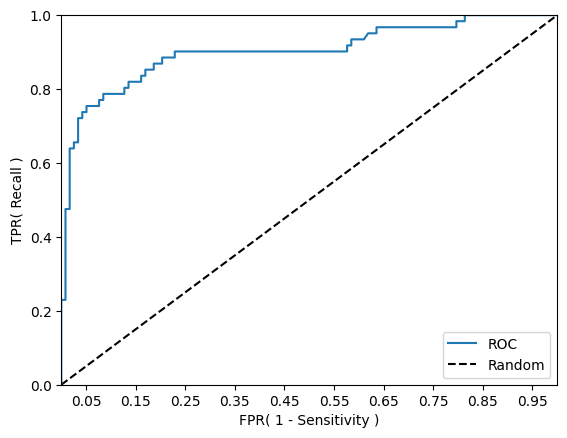

In [30]:
def roc_curve_plot(y_test, pred_proba_c1):
  #임곗값에 따른 FPR, TPR 값을 반환받음
  fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
  #ROC 곡선을 그래프 곡선으로 그림
  plt.plot(fprs, tprs, label = 'ROC')
  #가운데 대각선 직선을 그림
  plt.plot([0, 1], [0, 1], 'k--', label = 'Random')

  #FPR X축의 Scale을 0.1 단위로 변경, X, Y축 명 설정 등
  start, end = plt.xlim()
  plt.xticks(np.round(np.arange(start, end, 0.1), 2))
  plt.xlim(0, 1);plt.ylim(0, 1)
  plt.xlabel('FPR( 1 - Sensitivity )');plt.ylabel('TPR( Recall )')
  plt.legend()

roc_curve_plot(y_test, pred_proba[:, 1])

In [31]:
from sklearn.metrics import roc_auc_score

pred = lr_clf.predict(X_test)
roc_score = roc_auc_score(y_test, pred)
print('ROC AUC 값: {0:.4f}'.format(roc_score))

ROC AUC 값: 0.8341


In [32]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)
  #ROC-AUC 추가
  roc_auc = roc_auc_score(y_test, pred_proba)
  print('오차행렬')
  print(confusion)
  #ROC-AUC print 추가
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

ROC 곡선 : FPR이 변할 때 TPR이 어떻게 변하는 지를 나타낸 곡선
- TPR : 재현율, 민감도, 실제값 1이 정확히 예측되어야 하는 수준
- TNR : True Negative Rate, 특이성, 실제값 0이 정확히 예측되어야하는 수준 = TN/(FP+TN)
- FPR을 0에서 1까지 변경해가면서 TPR의 변화 값을 구하는데 이 때 곡선을 그리면 그게 ROC Curve
- AUC는 위에서 그린 ROC Curve의 밑의 면적으로 최댓값은 1
